In [128]:
import warnings
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.tree import export_graphviz
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Introdução

In [47]:
uri_tracking = 'https://gist.githubusercontent.com/guilhermesilveira/b9dd8e4b62b9e22ebcb9c8e89c271de4/raw/c69ec4b708fba03c445397b6a361db4345c83d7a/tracking.csv'
uri_projetos = 'https://gist.githubusercontent.com/guilhermesilveira/12291c548acaf544596795709020e3db/raw/325bdef098bd9cbc2189215b7e32e22f437f29f3/projetos.csv'

db_tracking = pd.read_csv(uri_tracking, header=0)
db_projetos = pd.read_csv(uri_projetos, header=0)

In [48]:
db_tracking.head()

,inicial,palestras,contato,comprou,patrocinio
0,1,1,0,0,0
1,1,1,0,0,0
2,1,1,0,0,0
3,1,1,0,0,0
4,1,1,0,0,0


In [49]:
y = db_tracking['comprou']
x = db_tracking.drop(columns='comprou')

random_seed = 2102

treino_x, teste_x, treino_y, teste_y =  train_test_split(x, y, train_size=0.75, test_size=0.25, random_state=random_seed, stratify=y)
#o método statify ajusta automaticamente o modelo para ter certeza que o modelo estará bem distribuido de variáveis x e y.

In [50]:
model_linear_svc = LinearSVC()
model_linear_svc.fit(treino_x, treino_y)


previsoes_model_linear_svc = model_linear_svc.predict(teste_x)
accuracy_model_linear_svc = accuracy_score(teste_y, previsoes_model_linear_svc)*100

print(f'Acurácia do modelo: {accuracy_model_linear_svc:.4f}%')

Acurácia do modelo: 92.0000%


In [51]:
treino_y.value_counts()

,count
comprou,
0,49
1,25


In [52]:
teste_y.value_counts()

,count
comprou,
0,17
1,8


#Segunda Parte - Linear SVC

In [53]:
db_projetos.head()

,nao_finalizado,horas_esperadas,preco
0,0,75.0,6985.000000
1,1,0.0,4325.293458
2,0,87.0,14205.000000
3,1,13.0,100.000000
4,0,2.0,202.000000


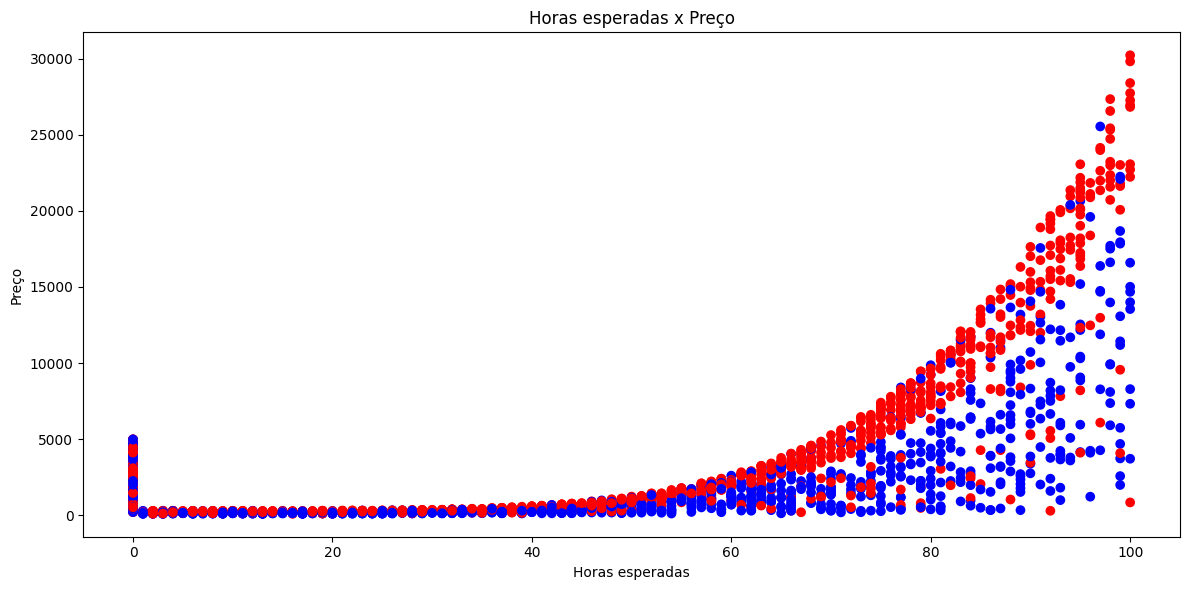

In [54]:
map = {

       1:0,
       0:1
}

db_projetos['finalizado'] = db_projetos['nao_finalizado'].map(map)

fig = plt.figure(figsize=(12,6))

plt.scatter(db_projetos['horas_esperadas'], db_projetos['preco'], c=db_projetos['finalizado'], cmap='bwr')
plt.title('Horas esperadas x Preço', fontsize=12)
plt.xlabel('Horas esperadas', fontsize=10)
plt.ylabel('Preço', fontsize=10)

plt.tight_layout()
plt.show()

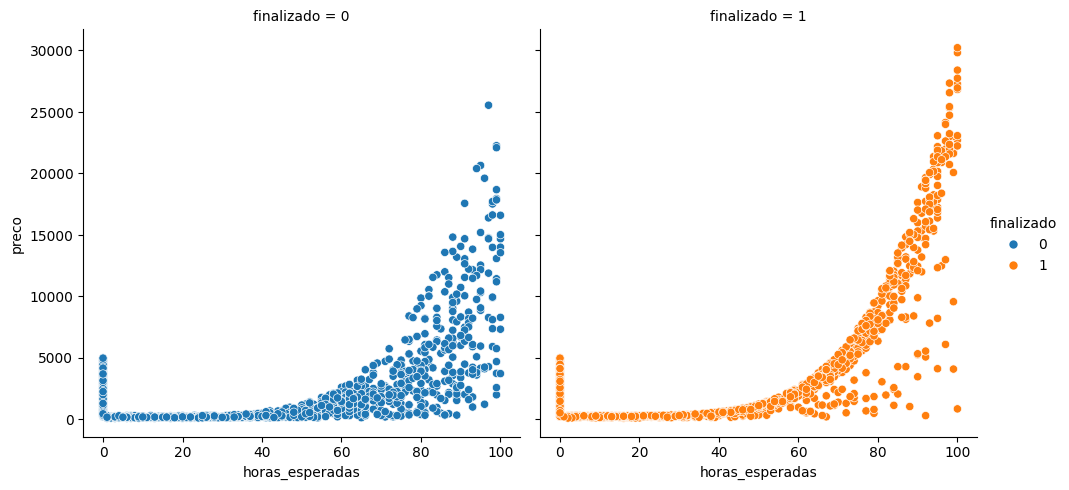

In [55]:
sns.relplot(data=db_projetos,x='horas_esperadas',y='preco', hue='finalizado', col='finalizado')

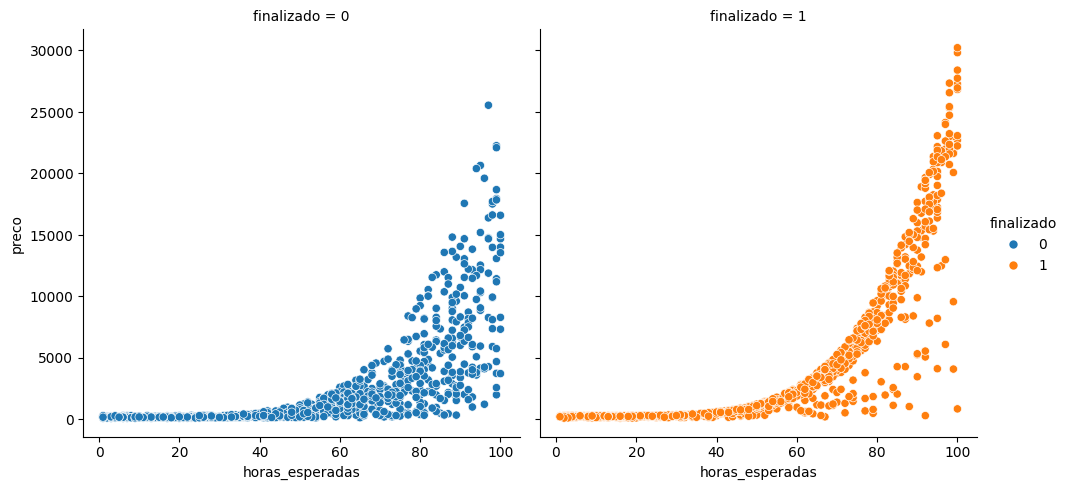

In [56]:
db_projetos_att = db_projetos.loc[db_projetos['horas_esperadas']> 0].reset_index(drop=True)

sns.relplot(data=db_projetos_att,x='horas_esperadas',y='preco', hue='finalizado', col='finalizado')

In [57]:
x = db_projetos_att.drop(columns=['finalizado', 'nao_finalizado']).reset_index(drop=True)
y = db_projetos_att['finalizado']

ramdom_seed = 20

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=random_seed, stratify=y)

model_linear_svc = LinearSVC()
model_linear_svc.fit(X_train, y_train)
previsao_model = model_linear_svc.predict(X_test)
acuracia_modelo = accuracy_score(y_test, previsao_model) * 100

print(f'Tamanho treino: {len(X_train)}')
print(f'Tamanho teste: {len(X_test)}')
print(f'Acurácia do modelo: {acuracia_modelo:.2f}%')

Tamanho treino: 1617
Tamanho teste: 540
Acurácia do modelo: 55.19%


In [58]:
media_finalizados = (y_test.sum() / len(y_test))*100
print(f'Em média, {media_finalizados:.2f}% são finalizados')
print(f'Modelo: {acuracia_modelo:.2f}% | Média: {media_finalizados:.2f}%')

Em média, 52.59% são finalizados
Modelo: 55.19% | Média: 52.59%


## Curva de decisão

In [59]:
#Para plotar a curva de decisão, precisamos definir os valores mínimos e máximos de x e y, para depois cruzar e 'recriar' todos os pixels do gráfico.

x_min = X_test['horas_esperadas'].min()
x_max = X_test['horas_esperadas'].max()
y_min = X_test['preco'].min()
y_max = X_test['preco'].max()

pixels = 100

eixo_x = np.arange(x_min, x_max, (x_max-x_min)/pixels)
eixo_y = np.arange(y_min, y_max, (y_max-y_min)/pixels)

#Depois de criar os 100 pontos dos eixos horizontais e verticais, precisamos cruzar todos os possíveis pares de x e y.

xx, yy = np.meshgrid(eixo_x, eixo_y)
pontos = np.c_[xx.ravel(), yy.ravel()]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


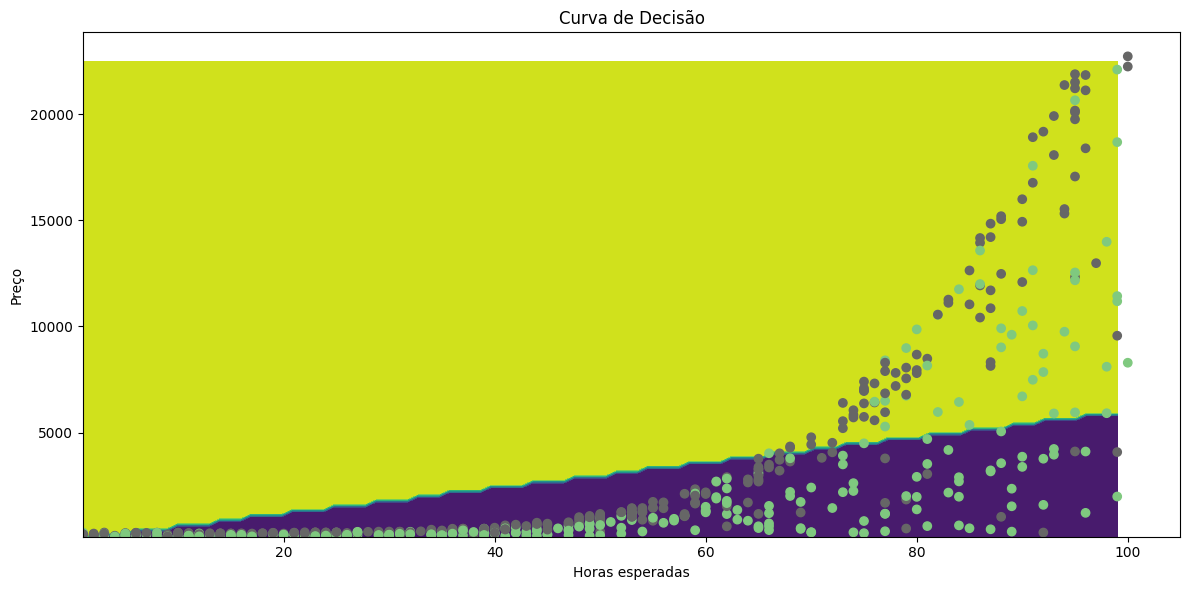

In [60]:
#Feito isso, podemos chamar o modelo.predict(pontos) para obter as previsões para cada ponto da grade. Por padrão, esse resultado será o Z, que representa as previsões para todo o grid.

Z = model_linear_svc.predict(pontos)
Z = Z.reshape(xx.shape)

fig = plt.figure(figsize=(12,6))

plt.contourf(xx, yy, Z)
plt.scatter(X_test['horas_esperadas'], X_test['preco'], c=y_test, cmap='Accent')
plt.title('Curva de Decisão', fontsize=12)
plt.xlabel('Horas esperadas', fontsize=10)
plt.ylabel('Preço', fontsize=10)

plt.tight_layout()
plt.show()

#Terceira Parte - SVC

## SVC

In [61]:
x = db_projetos_att.drop(columns=['finalizado', 'nao_finalizado']).reset_index(drop=True)
y = db_projetos_att['finalizado']

ramdom_seed = 20

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=random_seed, stratify=y)

model_svc = SVC(gamma='auto')
model_svc.fit(X_train, y_train)
previsao_model_svc = model_linear_svc.predict(X_test)
acc_model_svc = accuracy_score(y_test, previsao_model_svc) * 100

print(f'Acuracia do modelo: {acc_model_svc:.2f} | Média {media_finalizados:.2f}')

Acuracia do modelo: 55.19 | Média 52.59


In [62]:
pixels = 100

x_min = X_test['horas_esperadas'].min()
x_max = X_test['horas_esperadas'].max()
y_min = X_test['preco'].min()
y_max = X_test['preco'].max()

eixo_x = np.arange(x_min, x_max, (x_max-x_min)/pixels)
eixo_y = np.arange(y_min, y_max, (y_max-y_min)/pixels)

xx, yy = np.meshgrid(eixo_x, eixo_y)
pontos = np.c_[xx.ravel(), yy.ravel()]
Z = model_svc.predict(pontos)
Z = Z.reshape(xx.shape)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


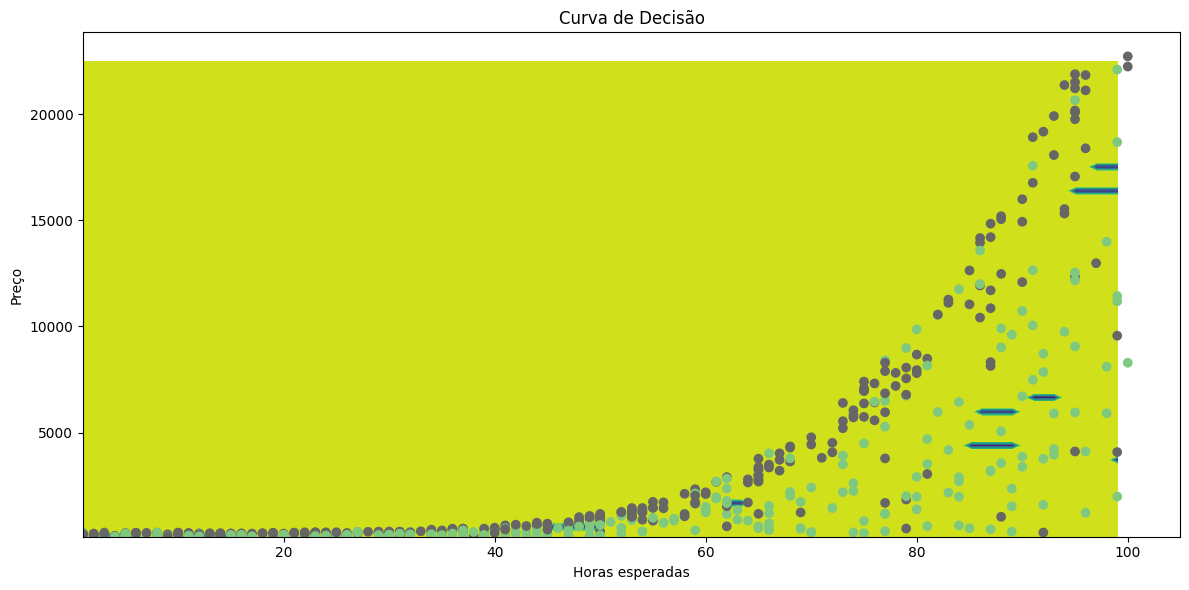

In [63]:
fig = plt.figure(figsize=(12,6))

plt.contourf(xx, yy, Z)
plt.scatter(X_test['horas_esperadas'], X_test['preco'], c=y_test, cmap='Accent')
plt.title('Curva de Decisão', fontsize=12)
plt.xlabel('Horas esperadas', fontsize=10)
plt.ylabel('Preço', fontsize=10)

plt.tight_layout()
plt.show()

## SVC com Standar Scale

Standard Scaler é uma classe de pré-processamento de dados do scikit-learn. Auda a normalizar a escala dos dados, o que é crucial para muitos algoritmos de aprendizado de máquina que são sensíveis à variação nas escalas das características (features) dos dados.

**Mas como o StandardScaler funciona?**

Ao aplicar o método a um conjunto de dados, ela realzia as seguintes etapas para cada característica:
- Calcula a média de cada característica (coluna?)
- Calcula o desvio padrão de cada característica, medindo o quão despersos estão os valores em relação a média
- Normaliza os valores subtraindo a média e dividindo pelo desvio padrão para cada valor de característica.
- Formula: Ζ = (xᵢ-μ)/s. Onde:
  - Ζ - Valor padronizado;
  - xᵢ - Valor observado;
  - μ - média amostral;
  - s - desvio padrão amostral.

Este processo de normalização ajusta os dados de tal forma que a média das características transformadas é zero e o desvio padrão é um. Isso é importante porque muitos algoritmos de machine learning performam melhor quando as características estão na mesma escala.

Assim, a StandardScaler() ajuda a garantir que o modelo de aprendizado de máquina não seja indevidamente influenciado por variações na escala ou na distribuição dos dados de entrada.

In [64]:
x = db_projetos_att.drop(columns=['finalizado', 'nao_finalizado']).reset_index(drop=True)
y = db_projetos_att['finalizado']

random_seed = 20

X_train_raw, X_test_raw, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=random_seed, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train_raw)

X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

model_svc = SVC(gamma='auto')
model_svc.fit(X_train, y_train)
previsao_model_svc = model_svc.predict(X_test)
acc_model_svc = accuracy_score(y_test, previsao_model_svc) * 100

print(f'Acuracia do modelo: {acc_model_svc:.2f}% | Média {media_finalizados:.2f}%')

Acuracia do modelo: 68.52% | Média 52.59%


In [65]:
data_col1 = X_test[:, 0]
data_col2 = X_test[:, 1]

pixels = 100

x_min = data_col1.min()
x_max = data_col1.max()
y_min = data_col2.min()
y_max = data_col2.max()

eixo_x = np.arange(x_min, x_max, (x_max-x_min)/pixels)
eixo_y = np.arange(y_min, y_max, (y_max-y_min)/pixels)

xx, yy = np.meshgrid(eixo_x, eixo_y)
pontos = np.c_[xx.ravel(), yy.ravel()]

Z = model_svc.predict(pontos)
Z = Z.reshape(xx.shape)

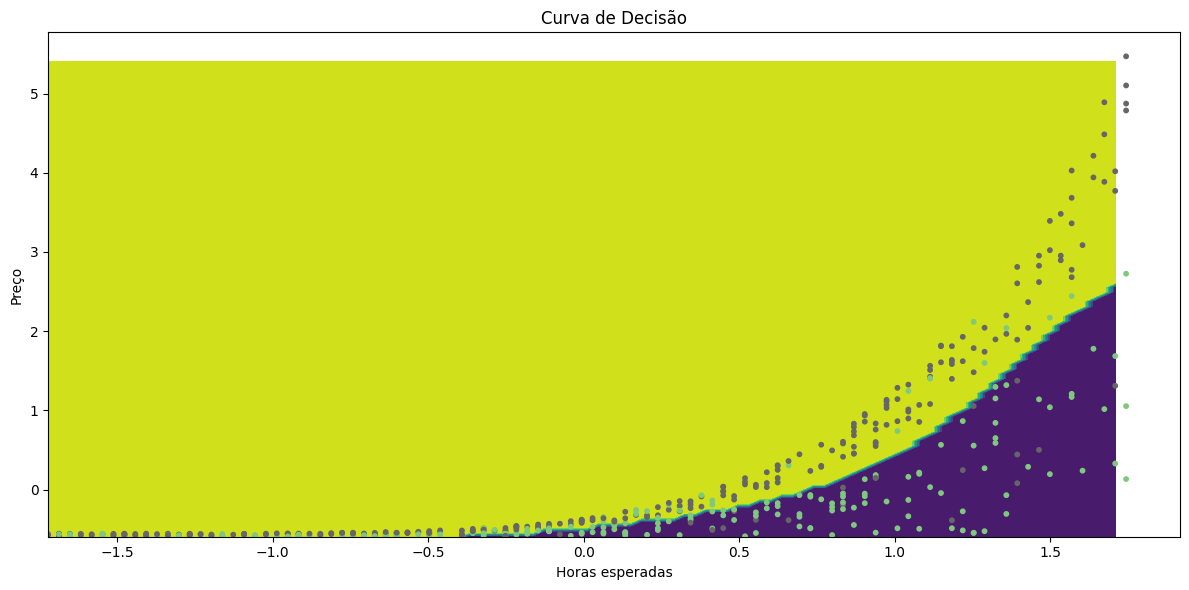

In [66]:
fig = plt.figure(figsize=(12,6))

plt.contourf(xx, yy, Z)
plt.scatter(data_col1, data_col2, c=y_test, cmap='Accent',s=10)
plt.title('Curva de Decisão', fontsize=12)
plt.xlabel('Horas esperadas', fontsize=10)
plt.ylabel('Preço', fontsize=10)

plt.tight_layout()
plt.show()

#Quarta Parte - Para saber mais

In [120]:
db_carros = pd.read_csv('https://gist.githubusercontent.com/guilhermesilveira/dd7ba8142321c2c8aaa0ddd6c8862fcc/raw/e694a9b43bae4d52b6c990a5654a193c3f870750/precos.csv')

db_carros['km_por_ano'] = db_carros['milhas_por_ano']*1.60934
db_carros['idade'] = datetime.today().year - db_carros['ano_do_modelo']

db_carros.drop(['milhas_por_ano', 'ano_do_modelo'], inplace=True, axis=1)

x = db_carros[['idade','km_por_ano','preco']]
y = db_carros[['vendido']]

random_seed = 20

##Dummy Classifier

In [121]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(x, y, random_state=random_seed, stratify=y)

#DummyClassifier

classificador = DummyClassifier(strategy='stratified') #existem dois métodos. o automático ele calcula os casos que ocorrem / qtde de ocorências, aqui ele
classificador.fit(X_train_raw, y_train)
previsoes = classificador.predict(X_test_raw)

acc_naive_model = accuracy_score(y_test, previsoes)*100
print(f'A acurácia do modelo ingênuo {acc_naive_model:.2f}%')

A acurácia do modelo ingênuo 52.20%


In [122]:
warnings.filterwarnings('ignore')
X_train_raw, X_test_raw, y_train, y_test = train_test_split(x, y, random_state=random_seed, stratify=y)

#Standard Scale
scaler = StandardScaler()
scaler.fit(X_train_raw)

X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

#Roda SVC

model_svc_carros = SVC(gamma='auto')
model_svc_carros.fit(X_train, y_train)
previsao_carros = model_svc_carros.predict(X_test)

acc_model_svc_carros = accuracy_score(y_test, previsao_carros) * 100

print(f'A acurácia do modelo é: {acc_model_svc_carros}% | O modelo simples propõe: {acc_naive_model:.2f}%')

A acurácia do modelo é: 75.92% | O modelo simples propõe: 52.20%


##DecisionTree Classifier e Graphviz

In [134]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=random_seed, stratify=y)

dtc_model = DecisionTreeClassifier(max_depth=3)
dtc_model.fit(X_train, y_train)
forecast_dtc_model = dtc_model.predict(X_test)
acc_dtc_model = accuracy_score(y_test, forecast_dtc_model)*100

print(f'A acurácia do DecisionTree é: {acc_dtc_model:.2f}%')

A acurácia do DecisionTree é: 78.40%


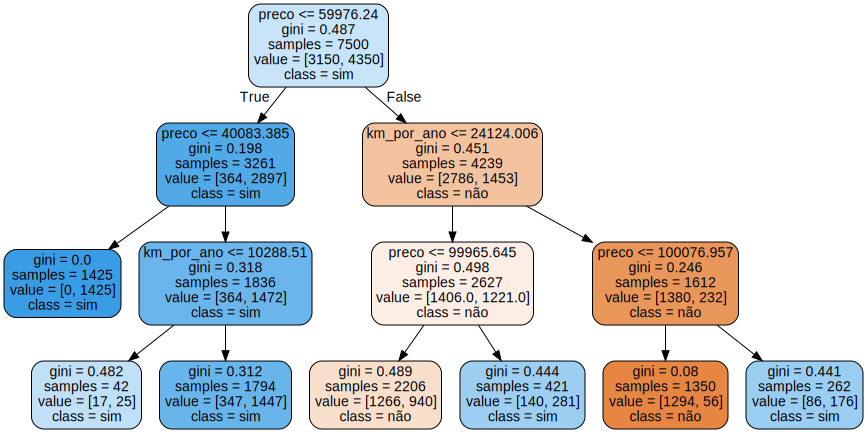

In [138]:
tree_decision = export_graphviz(dtc_model, filled=True, rounded=True, feature_names=x.columns, class_names=['não','sim'])
graph_tree_decision = graphviz.Source(tree_decision)
graph_tree_decision.render(filename='arvore_decisao', format='png', cleanup=True)

graph_tree_decision